# Unsupervised Learning Project 1

The car dataset was used in the 1983 American Statistical Association Exposition.

The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous variables.

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from scipy.stats import zscore 

### Load the data set

In [2]:
df = pd.read_csv('cars-dataset.csv')

In [3]:
print('Given car data-set has {} observations and {} features'.format(df.shape[0],df.shape[1]))

Given car data-set has 398 observations and 8 features


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [5]:
df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


'cyl' & 'yr' are multivalued discrete variables. Others are continuous variables & ignoring the 'car name' col for analysis

### hp column is shown as object , though the value captured seems like int. Hence, interpret it

In [6]:
df['hp'].nunique()

94

In [7]:
df['hp'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

There is a invalid character '?'

In [8]:
# check for each charater in the str is decimal or numeric, if not then display the records
df [df['hp'].str.isdecimal() == False ]

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98.0,?,2046,19.0,71,25.0
126,ford maverick,6,200.0,?,2875,17.0,74,21.0
330,renault lecar deluxe,4,85.0,?,1835,17.3,80,40.9
336,ford mustang cobra,4,140.0,?,2905,14.3,80,23.6
354,renault 18i,4,100.0,?,2320,15.8,81,34.5
374,amc concord dl,4,151.0,?,3035,20.5,82,23.0


In [9]:
# invalid characters cannot be directly converted to numeric type. Hence, assign it to NaN then convert to numeric
df['hp'].replace('?',np.nan,inplace=True)

In [10]:
# data point with NaN could not be converted into int. Hence, float type
df['hp'] = df['hp'].astype(np.float64)

### Check for missing values

In [11]:
df.isna().sum()

car name    0
cyl         0
disp        0
hp          6
wt          0
acc         0
yr          0
mpg         0
dtype: int64

### Handling missing values

From the above missing records, could see that the hp missing values can be filled by computing 
* the avg/median as a whole(for the hp col) and fill it 
* or subset the dataset further based on the other columns such as 'disp','wt' and fill the avg/median 

Filling the 'hp' missing value itself in-turn looks like a ML problem(regression) and seems may need domain knowledge to evaluate 

In [12]:
df.pivot_table(values='hp',index=['cyl'],columns=['disp','wt']).T.head()

cyl            3     4   5   6   8
disp wt                           
68.0 1867    NaN  49.0 NaN NaN NaN
70.0 2124   90.0   NaN NaN NaN NaN
     2330   97.0   NaN NaN NaN NaN
     2420  100.0   NaN NaN NaN NaN
71.0 1773    NaN  65.0 NaN NaN NaN

In [13]:
df.groupby(['cyl','disp','wt']).describe().T.head(12)

cyl           3                         4                                ...  \
disp      70.0                80.0  68.0  71.0        72.0  76.0  78.0   ...   
wt         2124  2330   2420   2720  1867  1773  1836  1613  1649  1985  ...   
hp  count   1.0   1.0    1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
    mean   90.0  97.0  100.0  110.0  49.0  65.0  65.0  69.0  52.0  52.0  ...   
    std     NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
    min    90.0  97.0  100.0  110.0  49.0  65.0  65.0  69.0  52.0  52.0  ...   
    25%    90.0  97.0  100.0  110.0  49.0  65.0  65.0  69.0  52.0  52.0  ...   
    50%    90.0  97.0  100.0  110.0  49.0  65.0  65.0  69.0  52.0  52.0  ...   
    75%    90.0  97.0  100.0  110.0  49.0  65.0  65.0  69.0  52.0  52.0  ...   
    max    90.0  97.0  100.0  110.0  49.0  65.0  65.0  69.0  52.0  52.0  ...   
acc count   1.0   1.0    1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
    mean   13.5  13.5   12.5   13.5  19.5  19.0  21.0  18.0  16.5  19.4  ...   
    std     NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
    min    13.5  13.5   12.5   13.5  19.5  19.0  21.0  18.0  16.5  19.4  ...   

cyl            8                                                          \
disp       400.0  429.0                440.0         454.0  455.0          
wt          5140   4341   4633   4952   4312   4735   4354   3086   4425   
hp  count    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
    mean   175.0  198.0  208.0  198.0  215.0  215.0  220.0  225.0  225.0   
    std      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
    min    175.0  198.0  208.0  198.0  215.0  215.0  220.0  225.0  225.0   
    25%    175.0  198.0  208.0  198.0  215.0  215.0  220.0  225.0  225.0   
    50%    175.0  198.0  208.0  198.0  215.0  215.0  220.0  225.0  225.0   
    75%    175.0  198.0  208.0  198.0  215.0  215.0  220.0  225.0  225.0   
    max    175.0  198.0  208.0  198.0  215.0  215.0  220.0  225.0  225.0   
acc count    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
    mean    12.0   10.0   11.0   11.5    8.5   11.0    9.0   10.0   10.0   
    std      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
    min     12.0   10.0   11.0   11.5    8.5   11.0    9.0   10.0   10.0   

cyl               
disp              
wt          4951  
hp  count    1.0  
    mean   225.0  
    std      NaN  
    min    225.0  
    25%    225.0  
    50%    225.0  
    75%    225.0  
    max    225.0  
acc count    1.0  
    mean    11.0  
    std      NaN  
    min     11.0  

[12 rows x 388 columns]

In [14]:
# As of now replace it(missing values) with column's median
df['hp'].replace(np.nan,df['hp'].median(),inplace=True)

In [15]:
df.isna().sum()

car name    0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
mpg         0
dtype: int64

### Univariate / Bi-variate analysis

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
hp,398.0,104.304020,38.222625,46.0,76.000,93.5,125.000,230.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


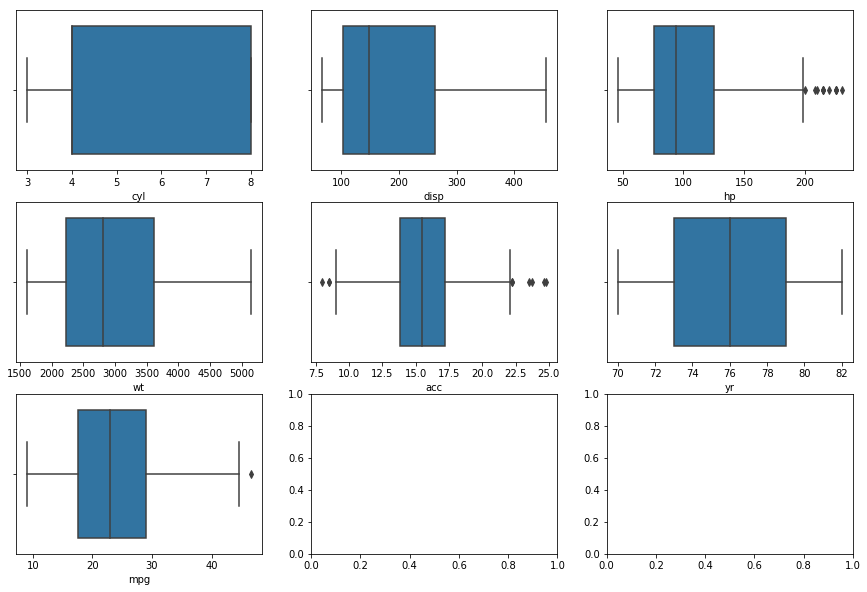

In [17]:
#Boxplot

i=j=0

fig, ax = plt.subplots(3,3,figsize=(15,10))

for col in df.select_dtypes(exclude=np.object).columns:
    sns.boxplot(data=df,x=col,ax=ax[i,j])
    j+=1
           
    if(j%3==0):
        i+=1
        j=0

#### Inference:

    > Outliers are there for columns 'mpg', 'acc' and 'hp'
    
    > Apporximately distribution for 'mpg','yr' & 'acc' are normal and this can inferred from .describe() mean/median 
      where both are same
      
    > Others are('wt','cyl','disp' & 'hp') right skewed, where mean is greater than median

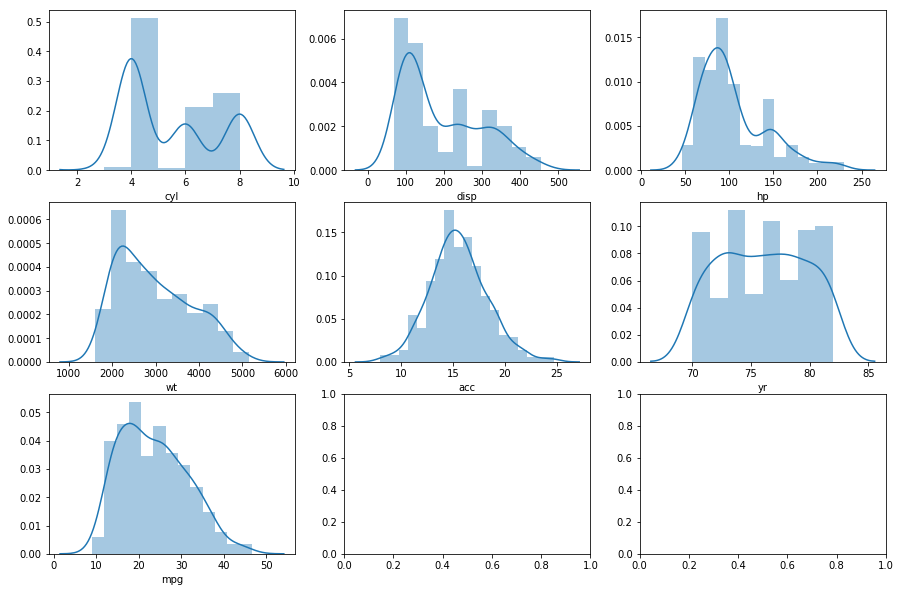

In [18]:
#Hist plot

i=j=0

fig, ax = plt.subplots(3,3,figsize=(15,10))

for col in df.select_dtypes(exclude=np.object).columns:
    sns.distplot(df[col],ax=ax[i,j])
    j+=1
        
    if(j%3==0):
        i+=1
        j=0

#### Inferences:

From the hist plot it can be inferred that

     * column 'cyl' clearly has 3 modes
     * In other columns 'wt', 'yr','hp' & 'disp' ~ 2 to 3 modes can be viewed
     
 Where the term mode is being interepted as class-label or cluster. Hence, in the case of un-supervised learning, in this example minimal of 2 cluster can be expected, at max 9 clusters. 

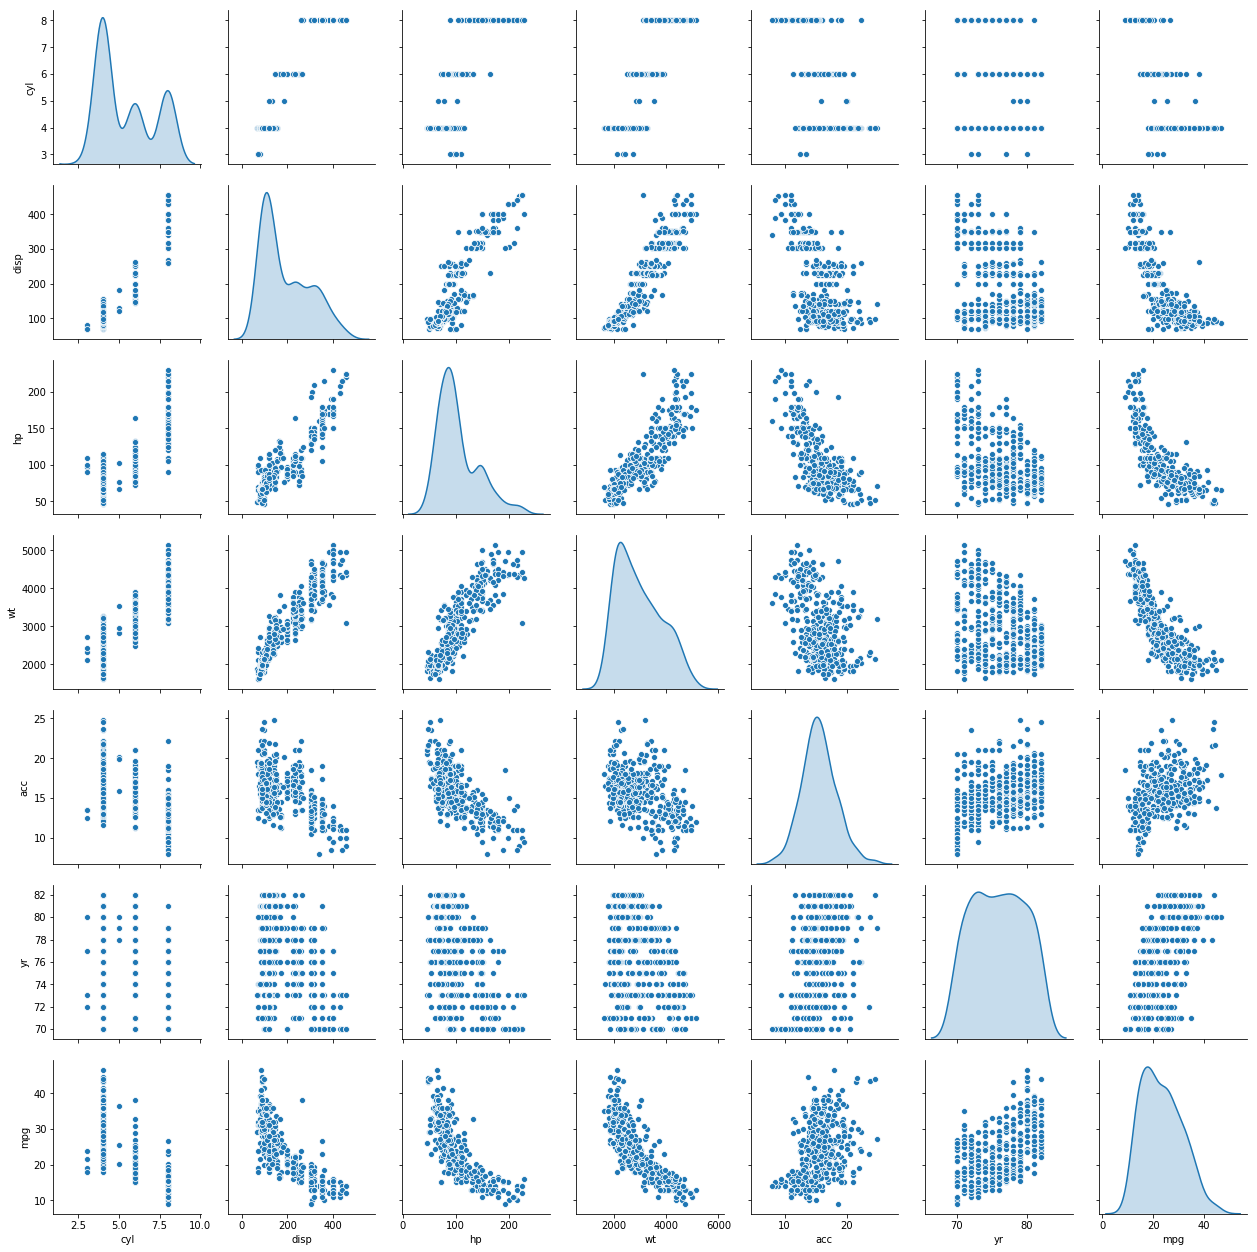

In [19]:
sns.pairplot(data=df, diag_kind='kde')

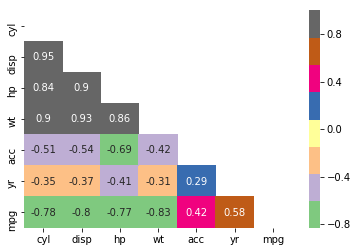

In [20]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap='Accent')

#### Inference:
    
    Col 'cyl' 
        Has good +ve relations with 'disp', 'hp' & 'wt'
        Has good -ve relations with 'mpg' & 'acc'
    
    Col 'disp'
        Has good +ve relations with 'hp' & 'wt'
        Has good -ve relations with 'mpg' & 'acc'
        
    Col 'hp'
        Has good +ve relations with 'cyl', 'disp' & 'wt'
        Has good -ve relations with 'mpg' & 'acc'
    
    Col 'wt'
        Has good +ve relations with 'cyl', 'disp' & 'hp'
        Has good -ve relations with 'mpg' & 'acc'
 
    Col 'acc' & 'mpg'
        Has some weak but +ve relations 
        Has -ve relations with other columns
 
    Col 'yr'
        Has moderate +ve relations with 'mpg'
        Has -ve relations with other columns

    
    

In [21]:
# drop the col 'car name' as it object type and it represents the car name which is of no use in out analysis
X = df.drop(columns=['car name'])

In [22]:
# Apply data scaling/transormation, as the columns are of different unit
X = X.apply(zscore)

In [23]:
X.shape

(398, 7)

### Selecting the number of clusters with silhouette analysis 

For n_clusters = 2 The average silhouette_score is : 0.48235946103916116
For n_clusters = 3 The average silhouette_score is : 0.35314791198988205
For n_clusters = 4 The average silhouette_score is : 0.34844881731503
For n_clusters = 5 The average silhouette_score is : 0.31497575273047274
For n_clusters = 6 The average silhouette_score is : 0.2741945945851742
For n_clusters = 7 The average silhouette_score is : 0.2815503657786723
For n_clusters = 8 The average silhouette_score is : 0.2689667243667542
For n_clusters = 9 The average silhouette_score is : 0.27445642619809785
For n_clusters = 10 The average silhouette_score is : 0.2623385201136238


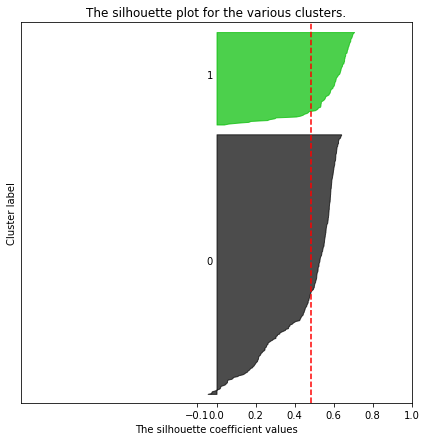

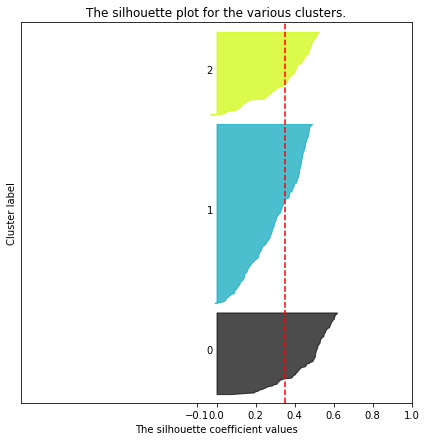

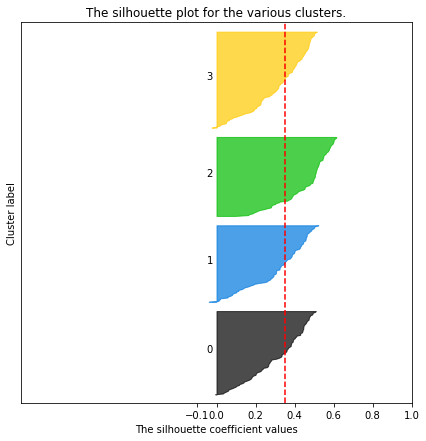

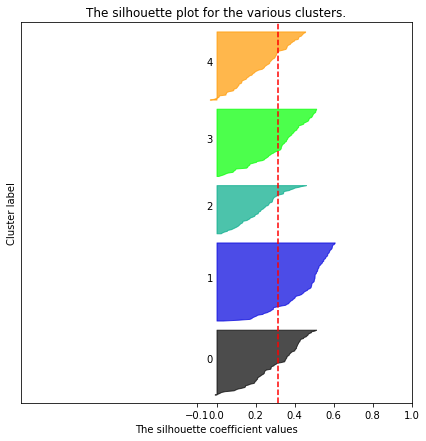

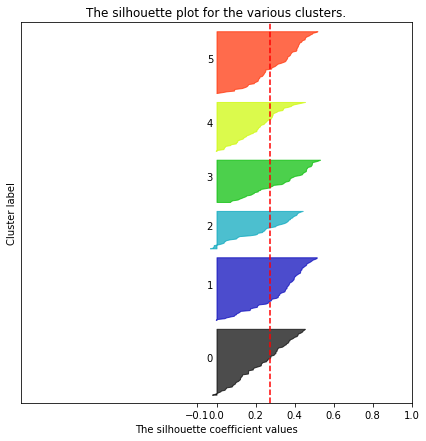

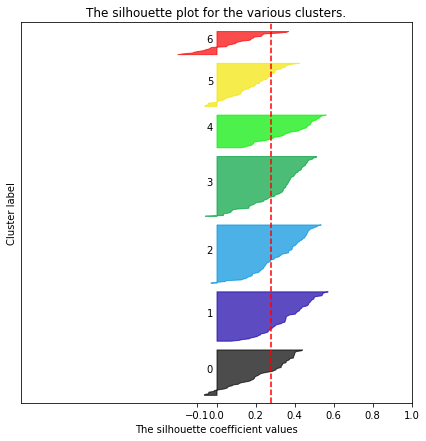

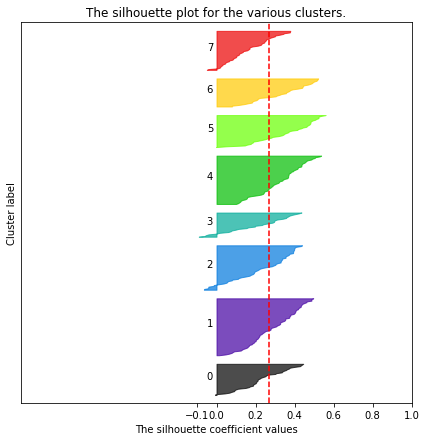

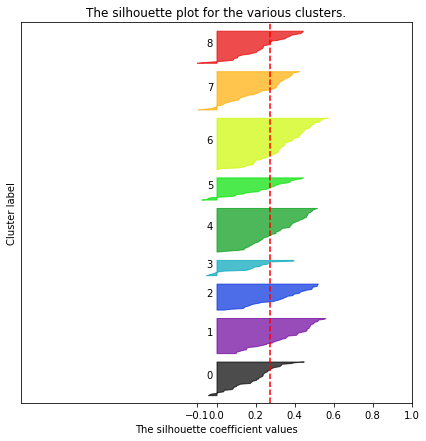

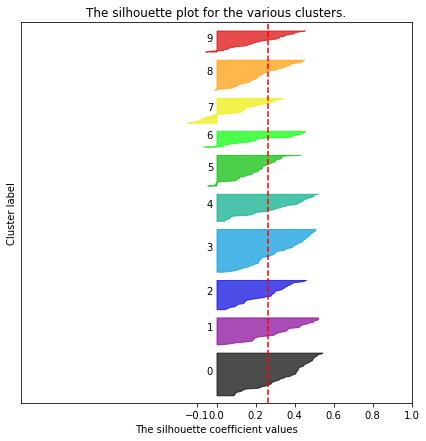

In [24]:
for n_clusters in range(2,10+1):
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    # The subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### Inferences:

 For the given data-set, 
    * When the number of cluster increases, the silhouette_score decreases
    * From the thickness of the silhouette plot,  
        > when the n_clusters=2, though the silhouette_score is the highest (but yet less than 0.5) it's cluster thickness
          are varying largely
        > when the n_clusters=4, the cluster size are almost similar
 
 Hence, from the silhouette plot analysis it is assumed the optimum clusters is 4 for the given data-set, as the cluster size are similar.

### Selecting the number of clusters with Elbow-plot analysis 


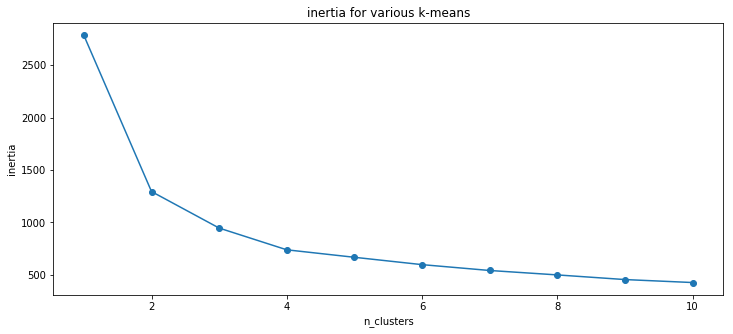

In [25]:
#captures the SSE/variance for the given cluster range
inertia = []

cluster_range = np.array(range(1,10+1))

for clusters in cluster_range:
    km = KMeans(n_clusters = clusters).fit(X)
    inertia.append(km.inertia_)
    
   
plt.figure(figsize=(12,5))
plt.plot(cluster_range, inertia,marker = "o")
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.title("inertia for various k-means")
plt.show()

### Inference:

From the above plot, it can be infered that 
    * As the cluster increases, error/variance decreases.
    * The variance drop significantly when the number of cluster is 2. Also next drop(moderate) happens for 3,
      hence assume that the given data-set can be clustered/classified into 2 to 3 groups

### Build the clusters for the optimum number found from the above Elbow-plot and silhouette plot analysis

>From silhouette analysis the optimum clusters found is 4, whereas from the Elbow-plot analysis the optimum cluster found is either 2 or 3. Hence, further building the clusters in the range(i.e clusters=3) between silhouette and Elbow-plot analysis range. Also, in the pairplot it have been inferred that in few dimensions the mode are 3 

#### Build the kmeans clustering for n_clusters=3


In [26]:
# Build the kmeans clustering for n_clusters=3
km = KMeans( n_clusters = 3, random_state = 3 )
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=3, tol=0.0001, verbose=0)

In [27]:
centroid_df = pd.DataFrame(km.cluster_centers_, columns = list(X) )
centroid_df

,cyl,disp,hp,wt,acc,yr,mpg
0,1.498191,1.500684,1.514129,1.400016,-1.076122,-0.672556,-1.158713
1,-0.853477,-0.803214,-0.675062,-0.785499,0.361334,0.309923,0.753947
2,0.357725,0.246878,-0.042755,0.308299,0.285786,-0.002721,-0.479054


In [28]:
km.inertia_

946.0197908553791

In [29]:
# Creating a new column "GROUP" which will hold the cluster id of each record
labels= km.predict(X)
X["Group"] = labels
X.groupby(['Group']).count()

,cyl,disp,hp,wt,acc,yr,mpg
Group,,,,,,,
0,95,95,95,95,95,95,95
1,207,207,207,207,207,207,207
2,96,96,96,96,96,96,96


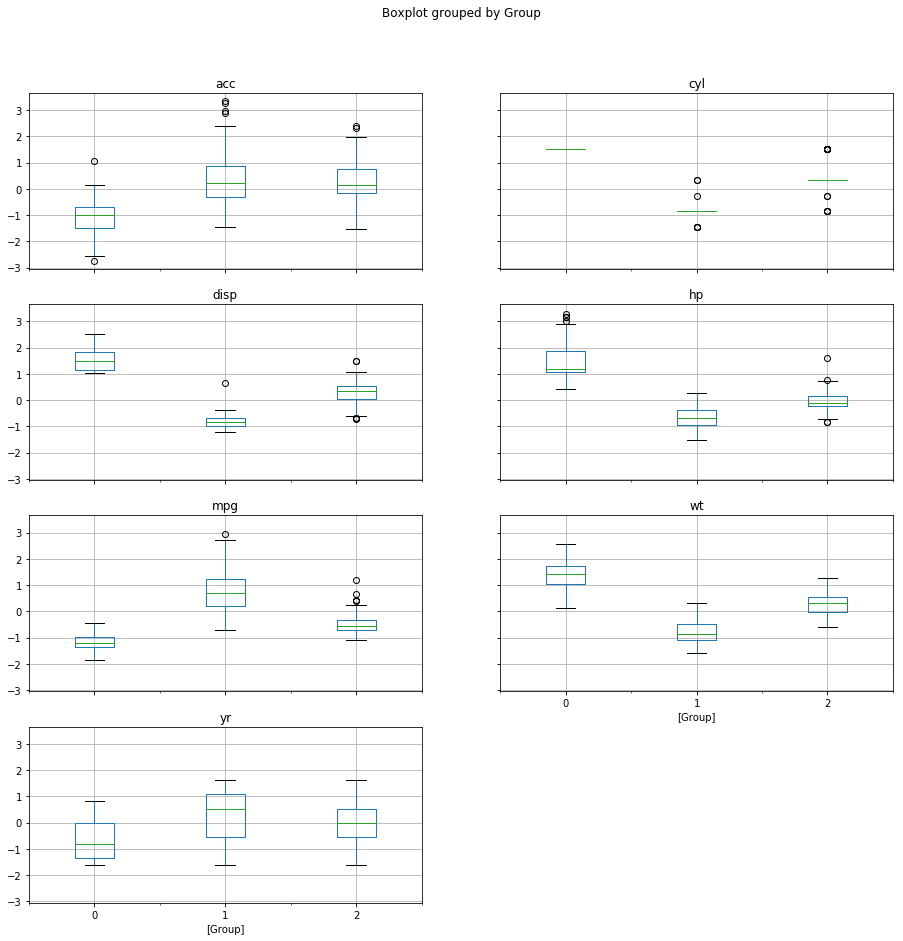

In [30]:
X.boxplot(by='Group', layout=(4,2), figsize=(15, 15))
plt.show()

In [31]:
df_km3 = X.pivot_table(values=['acc','disp','hp','mpg','wt'],index='Group',aggfunc='median')
df_km3

,acc,disp,hp,mpg,wt
Group,,,,,
0,-1.005035,1.503514,1.197027,-1.218855,1.441958
1,0.229433,-0.849116,-0.689046,0.702705,-0.870708
2,0.156817,0.360808,-0.112746,-0.571930,0.317549


### Inference:

    Roughly by interperting the 'mpg','wt','hp' & 'acc' w.r.t the clustered group from the above boxplot & pivot table,
    without any expetise in the auto-domain, approximately it can be said that the vehicle that has higher milleage 
    has lesser weight, displacment and horse-power and better accelration while compared to it's other heavier group.
    
    From the above inferences, the grouped/clustered data can be interpreted as follows 
        Group-1 is a Small vehicle ( and it's numbers are 207 of total 398 observations), 
        Group-0 is a Large vehicle and (95/398), 
        Group-2 is a in-between segment (96/398). 
    

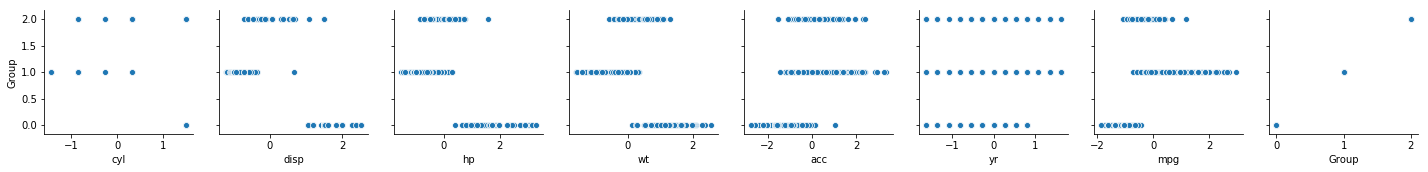

In [32]:
sns.pairplot(X,x_vars=X.columns,y_vars='Group')
plt.show()

### Build Linear-regression model for the dervied clusters

In [33]:
lr = LinearRegression()

#### Compute the co-efficient parameter

In [34]:
clr_lr_df = pd.DataFrame(index=np.array((range(0,km.n_clusters))),columns=[X.drop(columns='Group')])
clr_lr_df.index.name = 'Group'

for cluster in range(0, km.n_clusters):
 
 
    clus_df = X.loc[X['Group']== cluster]
    clus_df_X = clus_df.drop(columns=['Group'])
    clus_df_y = clus_df['Group']
    lr.fit(clus_df_X,clus_df_y)
    clr_lr_df.iloc[:cluster+1,:] = lr.coef_
    print('cluster-{}\'s linear model paramter intercept:{}'.format(cluster,lr.intercept_))
   
clr_lr_df

cluster-0's linear model paramter intercept:0.0
cluster-1's linear model paramter intercept:1.0
cluster-2's linear model paramter intercept:2.0


,cyl,disp,hp,wt,acc,yr,mpg
Group,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0


#### Using linear regression, find the accuracy for the whole data-set

In [35]:
x_train,x_test,y_train,y_test = train_test_split(X.drop(columns=['Group']), X['Group'], test_size=0.30, random_state=0)
print('\nTrain data-set size: {} {}'.format(x_train.shape,y_train.shape))
print('Test data-set size: {} {}'.format(x_test.shape,y_test.shape))
    
lr.fit(x_train,y_train)
    
print('\nTrain data-set R^2 score:',lr.score(x_train,y_train))
print('Test data-set R^2 score:',lr.score(x_test,y_test))   


Train data-set size: (278, 7) (278,)
Test data-set size: (120, 7) (120,)

Train data-set R^2 score: 0.41154595350813694
Test data-set R^2 score: 0.3548088758924065


#### Inference:
    The Linear regression model's accuracy score is quite low for both the train and test set, low score may be 
    due to outliers in the data-set.
    

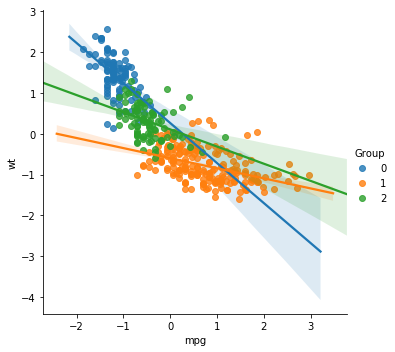

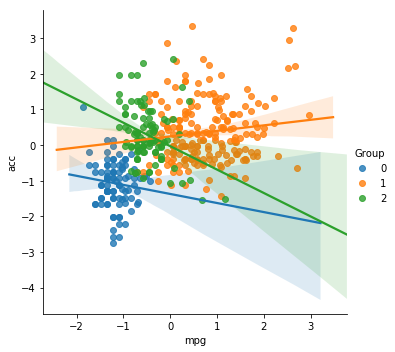

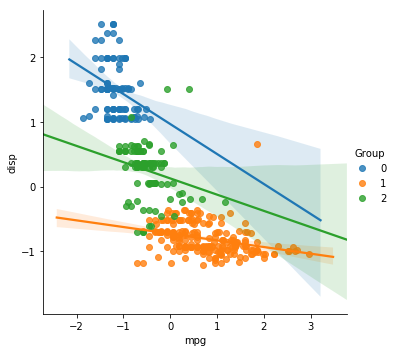

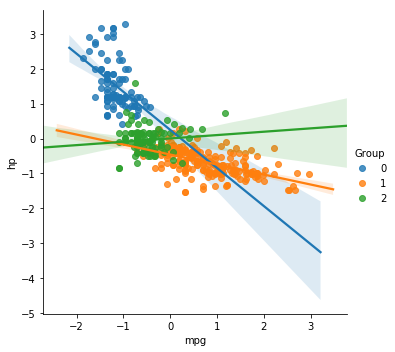

In [36]:
sns.lmplot(data=X, x='mpg', y='wt', hue='Group')
sns.lmplot(data=X, x='mpg', y='acc', hue='Group')
sns.lmplot(data=X, x='mpg', y='disp', hue='Group')
sns.lmplot(data=X, x='mpg', y='hp', hue='Group')
plt.show()

### Addressing outliers at group level

In [37]:

def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median() # replacing group outliers with group median      
    return group

data_corrected = (X.groupby('Group').transform(replace)) 
concat_data = data_corrected.join(pd.DataFrame(X['Group']))

C:\Users\Barani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


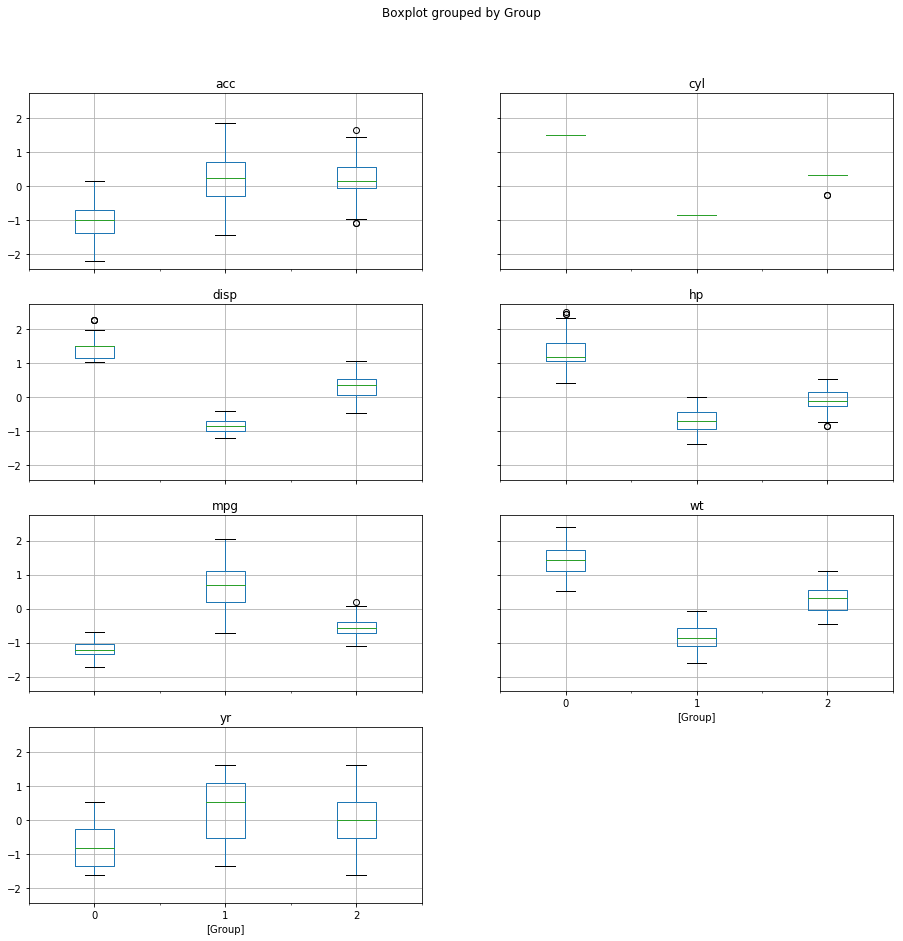

In [38]:
concat_data.boxplot(by='Group', layout=(4,2), figsize=(15, 15))
plt.show()

In [39]:
x_train,x_test,y_train,y_test = train_test_split(concat_data.drop(columns=['Group']), concat_data['Group'], test_size=0.30, random_state=0)
print('\nTrain data-set size: {} {}'.format(x_train.shape,y_train.shape))
print('Test data-set size: {} {}'.format(x_test.shape,y_test.shape))
    
lr.fit(x_train,y_train)
    
print('\nTrain data-set R^2 score:',lr.score(x_train,y_train))
print('Test data-set R^2 score:',lr.score(x_test,y_test))  


Train data-set size: (278, 7) (278,)
Test data-set size: (120, 7) (120,)

Train data-set R^2 score: 0.4878091825866917
Test data-set R^2 score: 0.4553982964408453


### Inference:
    After handling the outliers in the data-set at group level, though Linear regression model's test data-score increases 
    from 35% to 45% but yet it not so significant.

### EOF